# Definitions

In [1]:
from pathlib import Path

import pandas as pd
import lightgbm as lgb
from category_encoders import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
data_path = Path('.', 'data')

In [3]:
RANDOM_STATE = 648

In [4]:
target_name = 'dep_delayed_15min'

# Data

In [5]:
train = pd.read_csv(data_path.joinpath('flight_delays_train.csv'))
test = pd.read_csv(data_path.joinpath('flight_delays_test.csv'))

In [6]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [7]:
train[target_name] = train[target_name].map({"Y": 1, "N": 0})

In [8]:
train.shape

(100000, 9)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Month              100000 non-null  object
 1   DayofMonth         100000 non-null  object
 2   DayOfWeek          100000 non-null  object
 3   DepTime            100000 non-null  int64 
 4   UniqueCarrier      100000 non-null  object
 5   Origin             100000 non-null  object
 6   Dest               100000 non-null  object
 7   Distance           100000 non-null  int64 
 8   dep_delayed_15min  100000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 6.9+ MB


In [10]:
test.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


In [11]:
test.shape

(100000, 8)

## Split Data

In [12]:
X, y = train.drop(target_name, axis=1), train[target_name]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

# Preproc

## Exploration

<AxesSubplot:>

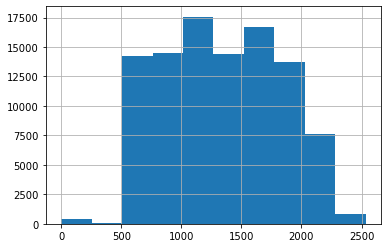

In [14]:
train.DepTime.hist()

In [15]:
train.DepTime.min(), train.DepTime.max()

(1, 2534)

## Route encoding

## Category encoding

In [16]:
cat_cols = X_train.select_dtypes(include=[object, 'category']).columns

In [17]:
cat_cols

Index(['Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'Origin', 'Dest'], dtype='object')

In [18]:
enc = OrdinalEncoder(cols=cat_cols,
                     handle_missing='return_nan',
                     handle_unknown='return_nan')

In [19]:
%%time
X_train[cat_cols] = enc.fit_transform(X_train[cat_cols])
X_train[cat_cols] = X_train[cat_cols].astype('category')

/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


CPU times: user 261 ms, sys: 30.3 ms, total: 292 ms
Wall time: 324 ms


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [20]:
%%time
X_test[cat_cols] = enc.transform(X_test[cat_cols])
X_test[cat_cols] = X_test[cat_cols].astype('category')

CPU times: user 92.4 ms, sys: 11.3 ms, total: 104 ms
Wall time: 120 ms


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


# Fit

In [21]:
model = lgb.LGBMClassifier()

In [68]:
lgbm_params = {'boosting': 'gbdt',
               'bagging_fraction': 0.8,
               'bagging_freq': 10,
               'feature_fraction': 0.5,
               'learning_rate': 0.1,
               'max_depth': 5,
               'min_data_in_leaf': int(0.1*len(X_train)),
               'n_jobs': 8,
               'num_leaves': 10,
               'n_estimators': 10_000,
               'reg_alpha': 5,
               'reg_lambda': 5,
               'random_state': RANDOM_STATE}

In [69]:
model.set_params(**lgbm_params)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting='rf',
               feature_fraction=0.5, max_depth=150, min_data_in_leaf=1,
               n_estimators=10000, n_jobs=8, num_leaves=10, random_state=648,
               reg_alpha=1, reg_lambda=1)

In [70]:
X_tr, X_es, y_tr, y_es = train_test_split(X_train, y_train,
                                          test_size=0.1,
                                          shuffle=True,
                                          random_state=RANDOM_STATE)

In [71]:
%%time
model.fit(X_tr, y_tr,
          eval_set=[(X_tr, y_tr), (X_es, y_es)],
          eval_metric=['auc'],
          early_stopping_rounds=100)

[LightGBM] [Warning] boosting is set=rf, boosting_type=gbdt will be ignored. Current value: boosting=rf
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[1]	training's auc: 0.692676	training's binary_logloss: 0.452697	valid_1's auc: 0.694109	valid_1's binary_logloss: 0.449885
Training until validation scores don't improve for 100 rounds
[2]	training's auc: 0.693878	training's binary_logloss: 0.45059	valid_1's auc: 0.696009	valid_1's binary_logloss: 0.447572


/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/Users/aapiskotin/opt/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[3]	training's auc: 0.698539	training's binary_logloss: 0.448416	valid_1's auc: 0.699827	valid_1's binary_logloss: 0.446042
[4]	training's auc: 0.69955	training's binary_logloss: 0.448021	valid_1's auc: 0.699902	valid_1's binary_logloss: 0.446175
[5]	training's auc: 0.699875	training's binary_logloss: 0.448007	valid_1's auc: 0.700206	valid_1's binary_logloss: 0.445938
[6]	training's auc: 0.700436	training's binary_logloss: 0.447567	valid_1's auc: 0.700751	valid_1's binary_logloss: 0.445656
[7]	training's auc: 0.700369	training's binary_logloss: 0.447509	valid_1's auc: 0.700574	valid_1's binary_logloss: 0.445709
[8]	training's auc: 0.701002	training's binary_logloss: 0.447525	valid_1's auc: 0.70024	valid_1's binary_logloss: 0.445912
[9]	training's auc: 0.701281	training's binary_logloss: 0.447588	valid_1's auc: 0.700299	valid_1's binary_logloss: 0.446024
[10]	training's auc: 0.701733	training's binary_logloss: 0.447577	valid_1's auc: 0.700889	valid_1's binary_logloss: 0.445915
[11]	trai

[69]	training's auc: 0.70973	training's binary_logloss: 0.445137	valid_1's auc: 0.707031	valid_1's binary_logloss: 0.443541
[70]	training's auc: 0.709668	training's binary_logloss: 0.445158	valid_1's auc: 0.706988	valid_1's binary_logloss: 0.443566
[71]	training's auc: 0.709715	training's binary_logloss: 0.445151	valid_1's auc: 0.706944	valid_1's binary_logloss: 0.443575
[72]	training's auc: 0.70979	training's binary_logloss: 0.445129	valid_1's auc: 0.707009	valid_1's binary_logloss: 0.443564
[73]	training's auc: 0.709785	training's binary_logloss: 0.445143	valid_1's auc: 0.707046	valid_1's binary_logloss: 0.443536
[74]	training's auc: 0.709861	training's binary_logloss: 0.445124	valid_1's auc: 0.707084	valid_1's binary_logloss: 0.443529
[75]	training's auc: 0.711504	training's binary_logloss: 0.445131	valid_1's auc: 0.708519	valid_1's binary_logloss: 0.443522
[76]	training's auc: 0.711626	training's binary_logloss: 0.445144	valid_1's auc: 0.70835	valid_1's binary_logloss: 0.443538
[77

[146]	training's auc: 0.711857	training's binary_logloss: 0.445112	valid_1's auc: 0.708321	valid_1's binary_logloss: 0.443731
[147]	training's auc: 0.711823	training's binary_logloss: 0.445127	valid_1's auc: 0.708341	valid_1's binary_logloss: 0.443736
[148]	training's auc: 0.711876	training's binary_logloss: 0.445115	valid_1's auc: 0.708349	valid_1's binary_logloss: 0.443737
[149]	training's auc: 0.71193	training's binary_logloss: 0.445105	valid_1's auc: 0.708358	valid_1's binary_logloss: 0.443739
[150]	training's auc: 0.711952	training's binary_logloss: 0.445091	valid_1's auc: 0.708369	valid_1's binary_logloss: 0.443744
[151]	training's auc: 0.712029	training's binary_logloss: 0.445082	valid_1's auc: 0.70837	valid_1's binary_logloss: 0.443732
[152]	training's auc: 0.712072	training's binary_logloss: 0.445068	valid_1's auc: 0.708353	valid_1's binary_logloss: 0.443736
[153]	training's auc: 0.712113	training's binary_logloss: 0.445056	valid_1's auc: 0.708308	valid_1's binary_logloss: 0.4

LGBMClassifier(bagging_fraction=0.8, bagging_freq=10, boosting='rf',
               feature_fraction=0.5, max_depth=150, min_data_in_leaf=1,
               n_estimators=10000, n_jobs=8, num_leaves=10, random_state=648,
               reg_alpha=1, reg_lambda=1)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='auc'>

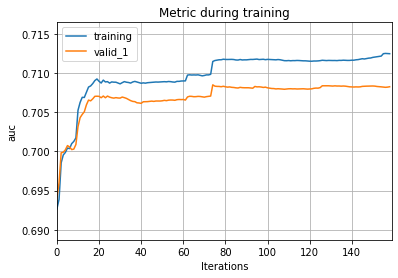

In [72]:
lgb.plot_metric(model, metric='auc')

In [73]:
fi = pd.Series(model.feature_importances_, index=X_tr.columns)

In [74]:
with pd.option_context('display.max_rows', None):
    display(fi)

Month             19
DayofMonth         5
DayOfWeek          1
DepTime          316
UniqueCarrier     32
Origin            66
Dest              62
Distance          30
dtype: int32

# Validate

In [75]:
roc_auc_score(y_tr, model.predict_proba(X_tr)[:, 1])

0.7089608988595162

In [76]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.7087397656558334

In [77]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.7018925000722819

# Commit

## Prepare test

In [33]:
test[cat_cols] = enc.transform(test[cat_cols])
test[cat_cols] = test[cat_cols].astype('category')

In [34]:
test['dep_delayed_15min'] = model.predict_proba(test.drop(target_name,
                                                          axis=1,
                                                          errors='ignore'))[:, 1]

In [35]:
test['dep_delayed_15min'].to_csv(data_path.joinpath('submit.csv'), index_label='id')

# Next Steps

* Grid Search through params
* datetime engineering (sin/cos transform, DepTime limits transform(?))

# Notes

* OHE sucks since model just doesn't use those features